# Making initial exploratory plots

In [1]:
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import pyranges as pr
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from collections import defaultdict
from matplotlib import font_manager
import numpy as np
import os

/users/jferrer/jmidgley/annotation_project/lib64/python3.9/site-packages/sorted_nearest/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

font_path = "../data_raw/fonts/LatinmodernmathRegular.otf"  
font_manager.fontManager.addfont(font_path)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
font = {'family' : 'Latin Modern Math',
       'weight' : 'normal',
       'size'   : 10}

mpl.rc('font', **font)
mpl.rc('lines', lw=1, c='k')
sns.set_context("notebook", font_scale=1, rc={"axes.linewidth": 1,
                                              "lines.linewidth": 1, 
                                              "font.size": 10,
                                              "axes.titlesize": 10,
                                              "axes.labelsize": 10,
                                              "legend.fontsize": 10,
                                              "xtick.labelsize": 8,
                                              "ytick.labelsize": 8})

In [3]:
combined_df = pd.read_csv( '../data_processed/curated_HIT.tsv', sep='\t')
combined_df.head()

/tmp/19432145/ipykernel_2299814/1091163101.py:1: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv( '../data_processed/curated_HIT.tsv', sep='\t')


,transcript_id,chr,exons,matched_to,category,unannotated_exons,Strand,summarized_category,ref_id,stripped_ref_id,...,relative_tx_exp,TSS_TPM_per_gene,Relative TSS usage,TSS_type,TSS_start,TSS_end,distance_to_closest_TSS,closest_TSS_ref_id,TSS distance category,TSS_name
0,ENCT00000006334.1,chr1,"[(61077274, 61077628), (61077916, 61079203)]","[(61077326, 61077628), (61077916, 61079231)]",GENCODE-annotated transcripts,NaN,+,GENCODE-annotated transcripts,ENST00000699992.1,ENST00000699992,...,0.036971,0.213765,0.044346,minor TSS,61077221.0,61077380.0,6.0,ENST00000699964.1,<=100bp,P3111_A
1,ENCT00000013056.1,chr1,"[(160261734, 160261922), (160281430, 160281892)]","[(160261682, 160261922), (160281430, 160281935)]",GENCODE-annotated transcripts,NaN,+,GENCODE-annotated transcripts,ENST00000756371.1,ENST00000756371,...,0.481821,0.743874,1.000000,unique TSS,160261726.0,160261763.0,0.0,ENST00000442130.1,<=100bp,P5604_A
2,ENCT00000019620.1,chr1,"[(239386568, 239387227), (239492709, 239492807...","[(239386568, 239387227), (239492709, 239492807...",GENCODE-annotated transcripts,NaN,+,GENCODE-annotated transcripts,ENST00000676153.1,ENST00000676153,...,0.149901,1.421490,0.454561,main TSS,239386576.0,239386587.0,8.0,ENST00000676153.1,<=100bp,P7900_A
3,ENCT00000022754.1,chr1,"[(23191893, 23195001), (23217291, 23217499)]","[(23191895, 23195001), (23217291, 23217502)]",GENCODE-annotated transcripts,NaN,-,GENCODE-annotated transcripts,ENST00000374619.2,ENST00000374619,...,0.553728,0.116743,1.000000,unique TSS,23217498.0,23217499.0,3.0,ENST00000374619.2,<=100bp,P1212_A
4,ENCT00000039204.1,chr1,"[(233319835, 233321155), (233327229, 233327357)]","[(233319834, 233321155), (233327229, 233327455)]",GENCODE-annotated transcripts,NaN,-,GENCODE-annotated transcripts,ENST00000771587.1,ENST00000771587,...,0.268948,2.093885,0.913948,main TSS,233327323.0,233327461.0,3.0,ENST00000771586.1,<=100bp,P7654_A


In [4]:
combined_df["Gene stable ID"].nunique()

22015

In [5]:
# How many genes have only unannotated tx
all_genes = set(combined_df["Gene stable ID"])

genes_with_gencode = set(combined_df.loc[combined_df["category"] == "GENCODE-annotated transcripts", "Gene stable ID"])

genes_without_gencode = all_genes - genes_with_gencode
len(genes_without_gencode)

8349

In [6]:
# How many genes have at least 1 unannotated tx
genes_with_unannotated = set(combined_df.loc[combined_df["category"] != "GENCODE-annotated transcripts", "Gene stable ID"])
len(genes_with_unannotated)

21428

## Plotting transcript categories

In [7]:
rename_map = {
    "GENCODE-annotated transcripts":                               "GENCODE-annotated",
    "Unannotated transcripts fully contained within GENCODE transcripts": "Contained within a GENCODE transcript",
    "Unannotated transcripts composed entirely of annotated exons":       "Composed of annotated exons (new splice variants)",
    "Transcripts with annotated exons and only overlapping unannotated exons": "Annotated + novel exons (overlap GENCODE)",
    "Transcripts with annotated exons and non-overlapping unannotated exons":  "Annotated + novel exons (≥1 non-overlapping)",
    "Fully unannotated transcripts with overlapping exons":               "Novel exons only (overlap GENCODE)",
    "Fully unannotated transcripts without any overlapping exons":        "Novel exons only (no overlap with GENCODE)"
}

In [8]:
class_code = (combined_df.groupby("category")["transcript_id"].count().rename(index=rename_map).rename_axis("category").to_frame("transcript_id"))
class_code = class_code.loc[rename_map.values()]

In [9]:
class_code

,transcript_id
category,
GENCODE-annotated,38890
Contained within a GENCODE transcript,25891
Composed of annotated exons (new splice variants),36485
Annotated + novel exons (overlap GENCODE),193904
Annotated + novel exons (≥1 non-overlapping),63911
Novel exons only (overlap GENCODE),13970
Novel exons only (no overlap with GENCODE),3291


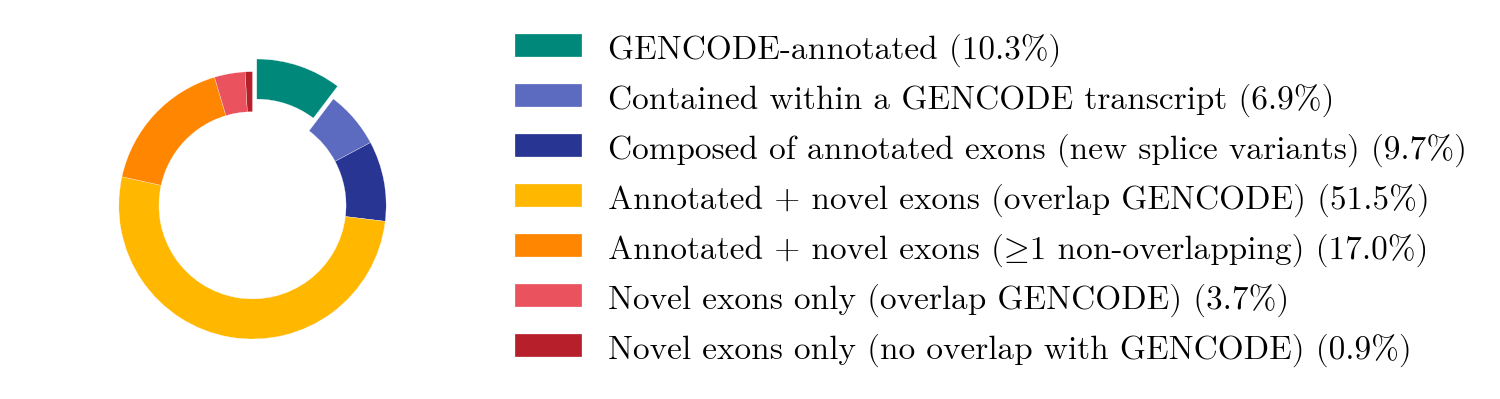

In [10]:
color_list = ['#00897B', '#5C6BC0', '#283593', '#FFB700', '#FF8600', '#EA525D', '#B71F2A']
labels = class_code.index
sizes = class_code['transcript_id']
explode = (0.1, 0, 0, 0, 0, 0, 0)

# Calculate percentages
total = sizes.sum()
percent_labels = [f"{label} ({size / total:.1%})" for label, size in zip(labels, sizes)]

# Plot
fig_class_code, ax = plt.subplots(figsize=(3, 2))
patches, texts = ax.pie(
    sizes,
    startangle=90,
    counterclock=False,
    radius=1,
    wedgeprops=dict(width=0.3, edgecolor='w'),
    explode=explode,
    colors=color_list[:len(sizes)]
)

for w in patches:
    w.set_linewidth(0.1)

# Add legend with percentages
ax.legend(patches, percent_labels, frameon=False, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

plt.axis('equal')
plt.show()

## Merging categories of all exons annotated

In [11]:
merge_map = {
    "Contained within a GENCODE transcript": 
        "All exons annotated",
    "Composed of annotated exons (new splice variants)": 
        "All exons annotated"
}

class_code = class_code.rename(index=merge_map)
class_code = class_code.groupby(class_code.index).sum()

order = [
    "GENCODE-annotated",
    "All exons annotated",
    "Annotated + novel exons (overlap GENCODE)",
    "Annotated + novel exons (≥1 non-overlapping)",
    "Novel exons only (overlap GENCODE)",
    "Novel exons only (no overlap with GENCODE)"
]
class_code = class_code.reindex(order)

class_code

,transcript_id
category,
GENCODE-annotated,38890
All exons annotated,62376
Annotated + novel exons (overlap GENCODE),193904
Annotated + novel exons (≥1 non-overlapping),63911
Novel exons only (overlap GENCODE),13970
Novel exons only (no overlap with GENCODE),3291


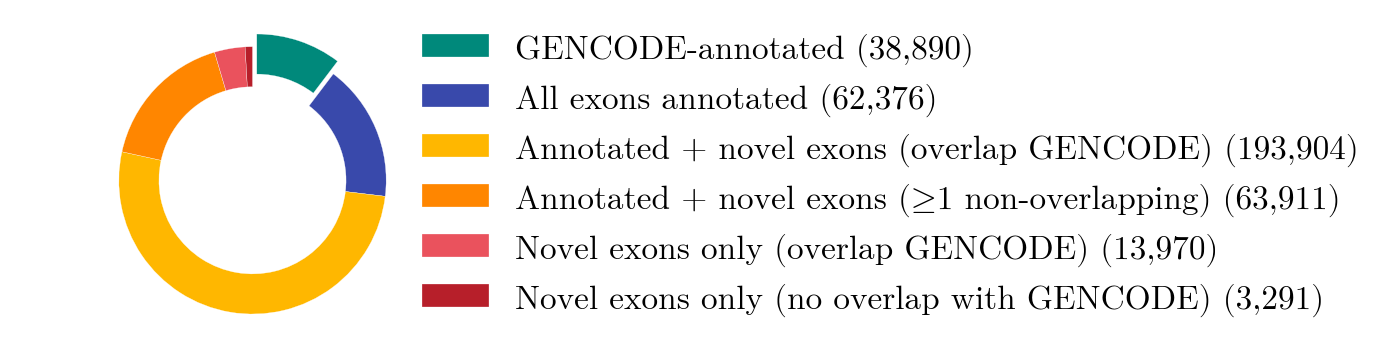

In [12]:
color_list = ['#00897B', '#3949AB', '#FFB700', '#FF8600', '#EA525D', '#B71F2A']
labels = class_code.index
sizes = class_code['transcript_id']
explode = (0.1, 0, 0, 0, 0, 0)

# Calculate percentages
total = sizes.sum()
percent_labels = [f"{label} ({size / total:.1%})" for label, size in zip(labels, sizes)]

# Label with actual numbers
number_labels = [f"{label} ({size:,.0f})" for label, size in zip(labels, sizes)]

# Plot
fig_class_code, ax = plt.subplots(figsize=(3, 2))
patches, texts = ax.pie(
    sizes,
    startangle=90,
    counterclock=False,
    radius=1,
    wedgeprops=dict(width=0.3, edgecolor='w'),
    explode=explode,
    colors=color_list[:len(sizes)]
)

for w in patches:
    w.set_linewidth(0.1)

# Add legend with percentages
ax.legend(patches, number_labels, frameon=False, loc='center left', bbox_to_anchor=(0.8, 0.5), fontsize=12)

plt.axis('equal')
os.makedirs("figures", exist_ok=True)
fig_class_code.savefig("figures/class_code_pie.pdf", bbox_inches='tight', dpi=300)
#fig_class_code.savefig("manuscript_figures/class_code_pie.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [13]:
# add these labels to combined_df
combined_df['plot_labels'] = pd.Categorical(combined_df['category'].map({k: merge_map.get(v, v) for k, v in rename_map.items()}), categories=order, ordered=True)

In [14]:
class_code.loc["Totals"] = class_code.select_dtypes("number").sum()
class_code

,transcript_id
category,
GENCODE-annotated,38890
All exons annotated,62376
Annotated + novel exons (overlap GENCODE),193904
Annotated + novel exons (≥1 non-overlapping),63911
Novel exons only (overlap GENCODE),13970
Novel exons only (no overlap with GENCODE),3291
Totals,376342


## Plotting gene types per transcript category

In [15]:
combined_df["Gene type"].value_counts()

Gene type
protein_coding                        330778
lncRNA                                 40995
transcribed_unprocessed_pseudogene       482
processed_pseudogene                     364
transcribed_unitary_pseudogene           136
TEC                                       59
unprocessed_pseudogene                    56
transcribed_processed_pseudogene          53
IG_V_gene                                 38
snRNA                                     29
misc_RNA                                  16
miRNA                                     15
snoRNA                                    14
TR_C_gene                                  5
scaRNA                                     5
unitary_pseudogene                         5
ribozyme                                   1
Name: count, dtype: int64

In [16]:
combined_df["gene_category"].value_counts()

gene_category
protein_coding     330778
lncRNA              40995
unmapped             3291
other_noncoding      1278
Name: count, dtype: int64

In [17]:
# At gene-level
combined_df.groupby("Gene stable ID")["gene_category"].first().value_counts()

gene_category
protein_coding     14996
lncRNA              4835
unmapped            1608
other_noncoding      576
Name: count, dtype: int64

In [18]:
counts_table = pd.crosstab(
    combined_df["summarized_category"],
    combined_df["gene_category"]
)
counts_table

gene_category,lncRNA,other_noncoding,protein_coding,unmapped
summarized_category,,,,
GENCODE-annotated transcripts,3145,223,35522,0
Unannotated transcripts with all exons annotated,5487,49,56840,0
Unannotated transcripts with annotated and unannotated exons,27409,569,229837,0
Unannotated transcripts without any annotated exons,4954,437,8579,3291


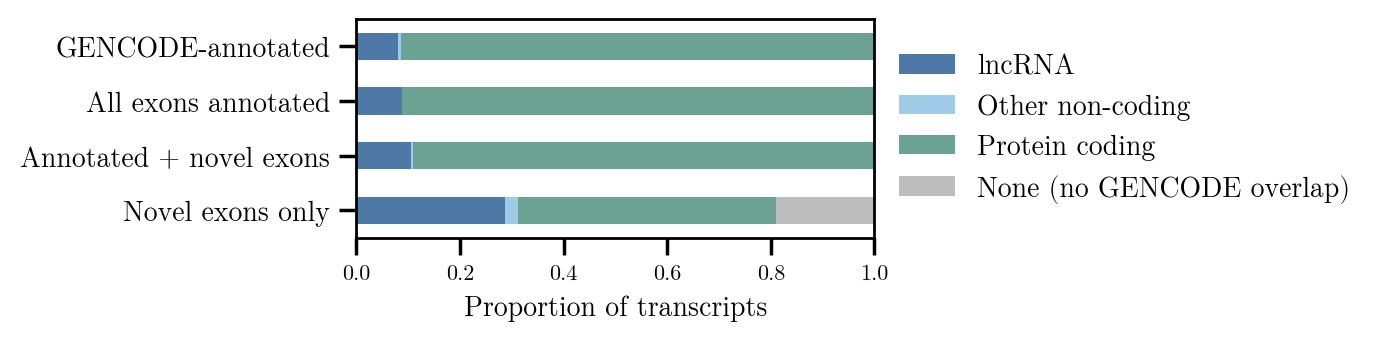

In [19]:
proportions = counts_table.div(counts_table.sum(axis=1), axis=0)

custom_colors = ['#4E79A7', '#A0CBE8', '#6BA292', "#bdbdbd"]

ax = proportions.plot(kind='barh', stacked=True, figsize=(7, 1.8), color=custom_colors)

custom_labels = ['lncRNA', 'Other non-coding', 'Protein coding', 'None (no GENCODE overlap)']  
ax.legend(
    custom_labels,
    loc='center left',           
    bbox_to_anchor=(1.0, 0.5),  
    frameon=False, 
    fontsize=10
)

custom_y_labels = ['GENCODE-annotated', 'All exons annotated', 'Annotated + novel exons', 'Novel exons only']
ax.set_yticks(range(len(custom_y_labels))) 
ax.set_yticklabels(custom_y_labels, fontsize=10)

plt.ylabel("")
plt.xlabel("Proportion of transcripts", fontsize=10)
ax.set_xlim(0, 1)
plt.tight_layout()
plt.gca().invert_yaxis()

plt.savefig("figures/tx_type.pdf", bbox_inches='tight', dpi=300)
#plt.savefig("manuscript_figures/tx_type.pdf", bbox_inches='tight', dpi=300)
plt.show()

## Plotting protein coding and lncRNA transcript categories

In [20]:
counts_long = counts_table.copy()
counts_long = counts_long.reset_index()

counts_long = counts_long.melt(id_vars='summarized_category', 
                                var_name='gene_category', 
                                value_name='transcript_count')

tx_type_coding = counts_long[counts_long['gene_category'] == 'protein_coding'].copy()
tx_type_lnc = counts_long[counts_long['gene_category'] == 'lncRNA'].copy()

In [21]:
tx_type_coding

,summarized_category,gene_category,transcript_count
8,GENCODE-annotated transcripts,protein_coding,35522
9,Unannotated transcripts with all exons annotated,protein_coding,56840
10,Unannotated transcripts with annotated and una...,protein_coding,229837
11,Unannotated transcripts without any annotated ...,protein_coding,8579


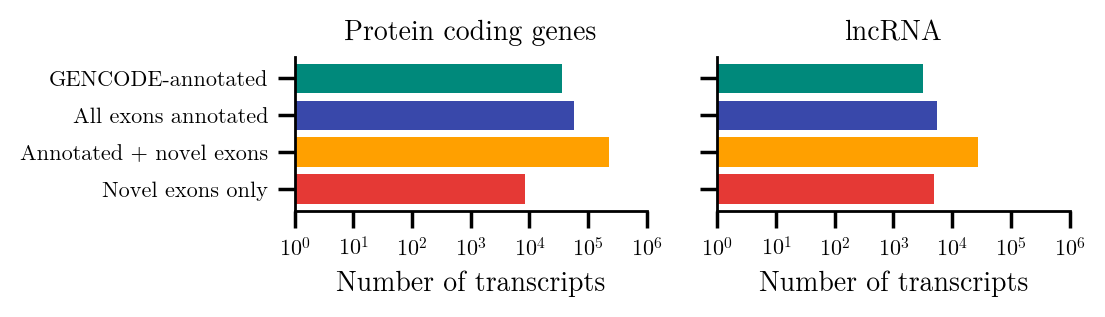

In [22]:
fig_tx_type, ax = plt.subplots(1,2, figsize=(5,1), sharey=True)

tx_color = [[0, 137, 123], [57, 72, 170], [255, 160, 0], [229, 57, 53]]
tx_color = [[i/255, j/255, k/255] for i,j,k in tx_color]

ax[0].barh(tx_type_coding['summarized_category'], tx_type_coding['transcript_count'], color=tx_color)


ax[1].barh(tx_type_lnc['summarized_category'], tx_type_lnc['transcript_count'], color=tx_color)

ax[0].invert_yaxis()
ax[0].set_title('Protein coding genes')
ax[1].set_title('lncRNA')
ax[0].set_xlabel('Number of transcripts')
ax[1].set_xlabel('Number of transcripts')

ax[0].set_yticks(range(len(custom_y_labels)))
ax[0].set_yticklabels(custom_y_labels)

for axes in ax:
    for spine in ['top', 'right']:
        axes.spines[spine].set_visible(False)
    axes.set_xscale("log")
    axes.set_xlim(1,1000000)
    axes.set_xticks(np.geomspace(1, 1000000, num=7))

## Plotting transcript expression

/tmp/19432145/ipykernel_2299814/3741390038.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(categories, fontsize=10)


Text(0.5, 0, 'Transcript expression (log2)')

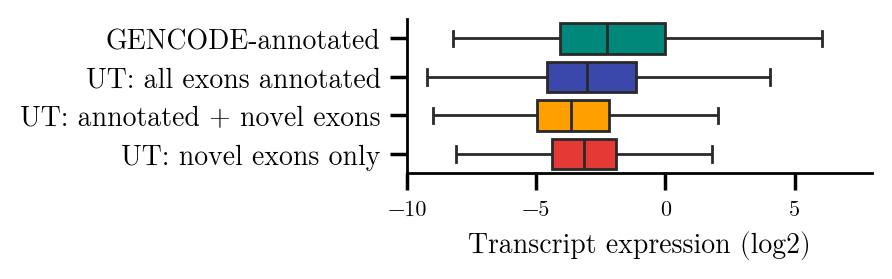

In [23]:
tx_color = [[0, 137, 123], [57, 72, 170], [255, 160, 0], [229, 57, 53]]
tx_color = [[i/255, j/255, k/255] for i,j,k in tx_color]
categories = ['GENCODE-annotated', 'UT: all exons annotated',
              'UT: annotated + novel exons', 'UT: novel exons only' ]

fig_exp, ax = plt.subplots(figsize=(3,1))
sns.boxplot(y='summarized_category', x='log2_tx_exp',
            orient='h',
            palette=tx_color, saturation=1,
            fliersize=0, hue='summarized_category',
            data=combined_df, ax=ax)
ax.set_xticks(np.arange(-10, 15, 5))
ax.set_xlim(-10,8)
sns.despine()
ax.set_yticklabels(categories, fontsize=10)
ax.set_ylabel('')
ax.set_xlabel('Transcript expression (log2)')

Text(0.5, 0, 'Transcript expression (log2)')

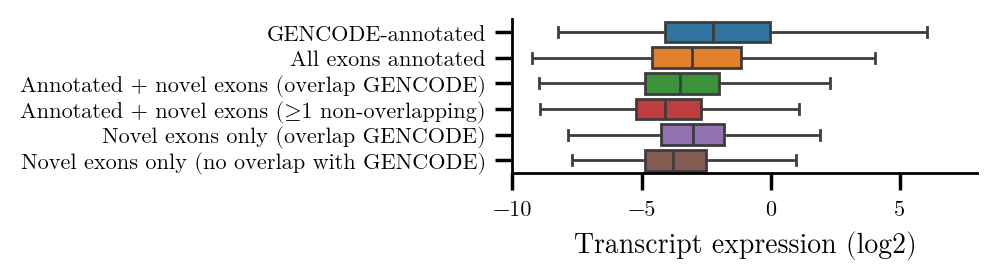

In [24]:
fig_exp, ax = plt.subplots(figsize=(3,1))
sns.boxplot(y='plot_labels', x='log2_tx_exp',
            orient='h',
            fliersize=0, hue='plot_labels',
            data=combined_df, ax=ax)
ax.set_xticks(np.arange(-10, 15, 5))
ax.set_xlim(-10,8)
sns.despine()
ax.set_ylabel('')
ax.set_xlabel('Transcript expression (log2)')

## Plotting lncRNAs

In [25]:
pd.set_option('display.max_columns', None)

In [26]:
lncRNA = combined_df[combined_df["gene_category"] == "lncRNA"]

In [27]:
len(lncRNA)

40995

In [28]:
lncRNA["Gene stable ID"].nunique()

4835

In [29]:
lncRNA[lncRNA["plot_labels"] == "GENCODE-annotated"]["Gene stable ID"].nunique()

1575

In [30]:
# genes that are never fully annotated
4835 - 1575

3260

In [31]:
# genes that have unannotated tx
lncRNA[lncRNA["plot_labels"] != "GENCODE-annotated"]["Gene stable ID"].nunique()

4701

In [34]:
class_code = (lncRNA.groupby("plot_labels")["transcript_id"].count().rename_axis("plot_labels").to_frame("transcript_id"))

/tmp/19432145/ipykernel_2299814/3123840174.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  class_code = (lncRNA.groupby("plot_labels")["transcript_id"].count().rename_axis("plot_labels").to_frame("transcript_id"))


In [35]:
class_code

,transcript_id
plot_labels,
GENCODE-annotated,3145
All exons annotated,5487
Annotated + novel exons (overlap GENCODE),19640
Annotated + novel exons (≥1 non-overlapping),7769
Novel exons only (overlap GENCODE),4954
Novel exons only (no overlap with GENCODE),0


In [37]:
class_code = class_code.iloc[:-1] 

In [38]:
class_code

,transcript_id
plot_labels,
GENCODE-annotated,3145
All exons annotated,5487
Annotated + novel exons (overlap GENCODE),19640
Annotated + novel exons (≥1 non-overlapping),7769
Novel exons only (overlap GENCODE),4954


In [39]:
# % of tx that are not GENCODE annotated
class_code["transcript_id"].iloc[1:].sum() / len(lncRNA) *100

np.float64(92.32833272350287)

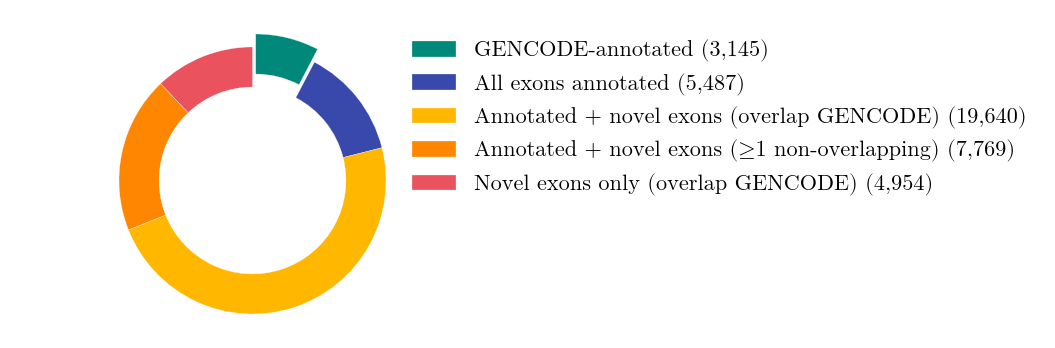

In [40]:
color_list = ['#00897B', '#3949AB', '#FFB700', '#FF8600', '#EA525D']
labels = class_code.index
sizes = class_code['transcript_id']
explode = (0.1, 0, 0, 0, 0)

# Calculate percentages
total = sizes.sum()
percent_labels = [f"{label} ({size / total:.1%})" for label, size in zip(labels, sizes)]

# Label with actual numbers
number_labels = [f"{label} ({size:,.0f})" for label, size in zip(labels, sizes)]

# Plot
fig_class_code, ax = plt.subplots(figsize=(3, 2))
patches, texts = ax.pie(
    sizes,
    startangle=90,
    counterclock=False,
    radius=1,
    wedgeprops=dict(width=0.3, edgecolor='w'),
    explode=explode,
    colors=color_list[:len(sizes)]
)

for w in patches:
    w.set_linewidth(0.1)

# Add legend with percentages
ax.legend(patches, number_labels, frameon=False, bbox_to_anchor=(0.8, 1), fontsize=8)

plt.axis('equal')
plt.show()

In [68]:
len(lncRNA) - 3145

37847